In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import glob

In [2]:
import sys
import os
from pathlib import Path
import json 
import os
sys.path.append(os.path.join(Path.cwd().parent, 'src' ) ) 
sys.path.append(os.path.join(Path.cwd().parent, 'src' , 'utils') ) 
sys.path.append(os.path.join(Path.cwd().parent))
print(sys.path)
from utils import load__concat_data_fivepin, create_plot_fivepin, create_stack_bar_5pin
from utils import process_data , apply_response_five_pin

['/Users/yangzejia/Desktop/Intention/notebooks', '/Users/yangzejia/anaconda3/lib/python311.zip', '/Users/yangzejia/anaconda3/lib/python3.11', '/Users/yangzejia/anaconda3/lib/python3.11/lib-dynload', '', '/Users/yangzejia/anaconda3/lib/python3.11/site-packages', '/Users/yangzejia/anaconda3/lib/python3.11/site-packages/aeosa', '/Users/yangzejia/Desktop/Intention/src', '/Users/yangzejia/Desktop/Intention/src/utils', '/Users/yangzejia/Desktop/Intention']


In [3]:
test_name = "llama-family"
file_dir = f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}'
os.makedirs(file_dir, exist_ok=True)
run_name = 'gpt-4-dataset-V2'
models =  [ "llama-7b-32k",
            "llama-7b-chat",
            "llama-13b-chat",
            "llama-70b-chat"]

In [4]:
import re
def load_files(model_name, run_name):
    file_path = f'/Users/yangzejia/Desktop/Intention/data/processed/model--{model_name}/d_name--{run_name}/'

    files = glob.glob(f'{file_path}/*/*.json')

    if len(files) != 38:
        print('ERROR: Not all topics have been processed')
    print(len(files))
    helpful_df, harmful_df   = process_for_plots(files , model_name, run_name  )
    return helpful_df, harmful_df 

def process_model(model_name, run_name):
    print(model_name)
    file_path = f'/Users/yangzejia/Desktop/Intention/data/processed/model--{model_name}/d_name--{run_name}/'

    files = glob.glob(f'{file_path}/*/*.json')

    if len(files) != 38:
        print('ERROR: Not all topics have been processed')
        
    helpful_df, harmful_df   = process_for_plots(files , model_name, run_name  )
    helpful_df, harmful_df = process_for_plots(files , model_name, run_name  )
    fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,10) , sharey= True) 
    ax=ax.ravel() 

    help(fig, ax[0], helpful_df, model_name)

    harm(fig, ax[1], harmful_df, model_name)


    fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{model_name}_{run_name}_comparison.png', bbox_inches='tight', )    
    
len_to_check = 10 

def process_for_plots(files , model_name, run_name ):
    # List to store each file's DataFrame
    print(model_name)
    dfs = []

    # Loop over each file in the folder
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
            if len(data) < len_to_check:
                print(len(data))
                print(f'ERROR: {file} has less than {len_to_check} entries')
                # exit()
            # Convert JSON data to a DataFrame
            # This assumes that your JSON structure is a list of records
            if isinstance(data, list):
                df = pd.DataFrame(data)
                dfs.append(df)
            else:
                print(f"File {file} does not contain a list of records.")

    # Concatenate all DataFrames into a single DataFrame
    large_table = pd.concat(dfs, ignore_index=True)
    large_table['model_name'] = model_name
    large_table['run_name'] = run_name
    # Now 'large_table' contains all the data from the JSON files


    # Assuming the column name is 'row'
    large_table['first_numeric'] = large_table['first response'].apply(lambda x: int(re.findall(r'\d', str(x))[0]) if re.findall(r'\d', str(x)) else None)
    large_table['second_numeric'] = large_table['second response'].apply(lambda x: int(re.findall(r'\d', str(x))[0]) if re.findall(r'\d', str(x)) else None)
    large_table['first_numeric'] = large_table['first_numeric'].astype('Int64')
    large_table['second_numeric'] = large_table['second_numeric'].astype('Int64')


    valid_keys = large_table['first_numeric'].isin([1, 2, 3, 4, 5])
    invalid_full_response_df = large_table[~valid_keys]
    print('Percentage invalid first responses' , len(invalid_full_response_df) / len(large_table) *100 , '%' )


    valid_keys = large_table['second_numeric'].isin([1, 2, 3, 4, 5])
    invalid_full_response_df = large_table[~valid_keys]
    print('Percentage invalid second responses' , len(invalid_full_response_df) / len(large_table) * 100, '%' )

    full_response_df = large_table[valid_keys].copy() 
    print('len of response: ', len(full_response_df))

    full_response_df['fr_label'] = [mapping[str(fr)]['label'] for fr , mapping in zip(full_response_df['first_numeric'], full_response_df['mapping_given_to_model']) ]
    full_response_df['sr_label'] = [mapping[str(sr)]['label'] for sr , mapping in zip(full_response_df['second_numeric'], full_response_df['mapping_given_to_model']) ]

    full_response_df['first_second_change?'] = full_response_df['first response'] != full_response_df['second response']

    # Splitting the DataFrame into two based on 'help/harm' column
    helpful_df = full_response_df[full_response_df['help/harm'] == 'Helpful']
    harmful_df = full_response_df[full_response_df['help/harm'] == 'Harmless']



    # Apply the function to create the new column
    helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
    harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1) 

    return helpful_df, harmful_df    



# Function to apply conditions
def determine_value(row):
    if not row['first_second_change?']:
        return 'Answer Unchanged'
    else:
        if row['fr_label'] == 'Helpful' and row['sr_label'] == 'Helpful':
            return 'Helpful Intent'
        elif row['fr_label'] == 'Helpful' and row['sr_label'] == 'Neutral':
            return 'Neutral Change'
        elif row['fr_label'] == 'Helpful' and row['sr_label'] == 'Unhelpful':
            return 'Unhelpful Change'
    return 'Other'  # For any cases that don't match the given conditions


# Function to apply conditions
def determine_value_harmless(row):
    if not row['first_second_change?']:
        return 'Answer Unchanged'
    else:
        if row['fr_label'] == 'Harmless' and row['sr_label'] == 'Harmless':
            return 'Harmless Intent'
        elif row['fr_label'] == 'Harmless' and row['sr_label'] == 'Neutral':
            return 'Neutral Change'
        elif row['fr_label'] == 'Harmless' and row['sr_label'] == 'Harmful':
            return 'Harmful Change'    
    return 'Other'  # For any cases that don't match the given conditions


def invert_dict(d):
        return {v: k for k, v in d.items()}





def get_cmap(h, label ):
    if label == 'sr_type':
        if h == 'Helpful':
            colour_mapping ={'Answer Unchanged': 'darkgrey', 'Helpful Intent': 'green', 'Neutral Change': 'lightblue', 'Other':'lemonchiffon', 'Unhelpful Change':'salmon'}
        elif h =='Harmless':
            colour_mapping ={'Answer Unchanged': 'darkgrey', 'Harmless Intent': 'green', 'Neutral Change': 'lightblue', 'Other':'lemonchiffon', 'Harmful Change':'salmon'}
    elif label == 'fr_label':
        if h == 'Helpful':
            colour_mapping = { 'Helpful':'lightgreen', 'Neutral':  'yellow',  'Unhelpful' : 'salmon',  'Somewhat Helpful':'lightgreen'}
        elif h =='Harmless':
            colour_mapping = { 'Harmless':'lightgreen', 'Neutral':  'yellow',  'Harmful' : 'salmon' , 'Somewhat Helpful':'lightgreen'} 
    elif label =='first_numeric':
        colour_mapping= {1: 'salmon', 2: 'lemonchiffon', 3: 'orange', 4: 'lightgreen', 5:'purple'}
    return colour_mapping

def help(fig, ax, helpful_df, model_name):
    h='Helpful'
    ax = plot_stacked(ax, h, helpful_df, 'fr_label', title= 'First Prompt Helpful')
    # ax .legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left') 
    ax = plot_stacked(ax, h, helpful_df, 'sr_type',  title = 'Adaptive Prompt ')
    #  add legend outside plots 
    ax.legend(title='Response', bbox_to_anchor=(2.85, 0.7), ) 

    # label y axes
    ax.set_ylabel('Percentage of Responses')    
    # /add fig title 
    ax.set_title(f'Dataset {h}')    

def harm(fig, ax, harmful_df, model_name):
    h = 'Harmless'    
    ax = plot_stacked(ax, h, harmful_df, label='fr_label', title= 'First Prompt Harmless')

    ax.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax = plot_stacked(ax, h, harmful_df, 'sr_type', title = 'Adaptive Prompt ')
    #  add legend outside plots
    ax.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
    # label y axes
    ax.set_ylabel('Percentage of Responses')
    # /add fig title
    ax.set_title(f'Dataset {h}')
    fig.suptitle(f'Comparison of Responses to First and Adaptive Prompts for Model {model_name}')
    



def plot_stacked(ax, h, data, label,  title=None ):
    # Count the occurrences of each label in 'fr_label'
    colour_mapping= get_cmap(h, label)

    label_counts = data[label].value_counts(normalize=True) * 100  # Get percentages
    
    print(label_counts)
    # Sort the index if necessary, so the order is consistent
    label_counts = label_counts.sort_index() 
    # Preparing the data for stacking

    categories = label_counts.index
    print(categories)
    
    colors = [colour_mapping[cat] for cat in categories]    

    bottom = 0  # Starting value for the bottom of each bar segment

    for i, category in enumerate(categories):
        # print(i, category) 
        ax.bar(f'{title}', label_counts[category], bottom=bottom, color=colors[i], label=str(category))
        ax.text(f'{title}', label_counts[category] /2 + bottom, f'{label_counts[category]:.1f}%', ha='center', va='bottom')
        bottom += label_counts[category]  # Update the bottom for the next category

    return ax 



def plot_stacked_responses(ax, h, data, label,  title=None ):
    # Count the occurrences of each label in 'fr_label'
    colour_mapping= {'1': 'red', '2': 'yellow', '3': 'orange', '4': 'green', '5':'purple'}

    label_counts = data[label].value_counts(normalize=True) * 100  # Get percentages

    # Sort the index if necessary, so the order is consistent
    label_counts = label_counts.sort_index() 
    # Preparing the data for stacking

    categories = label_counts.index
    print(categories)
 
    colors = [colour_mapping[cat] for cat in categories]    

    bottom = 0  # Starting value for the bottom of each bar segment

    for i, category in enumerate(categories):
        # print(i, category) 
        ax.bar(f'{title}', label_counts[category], bottom=bottom, color=colors[i], label=str(category))
        ax.text(f'{title}', label_counts[category] /2 + bottom, f'{label_counts[category]:.1f}%', ha='center', va='bottom')
        bottom += label_counts[category]  # Update the bottom for the next category

    return ax 



In [5]:
helplist = [] 
harmlist = [] 
for m in models:    
    file_path = f'/Users/yangzejia/Desktop/Intention/data/processed/model--{m}/d_name--{run_name}/'
    print(file_path)
    files = glob.glob(f'{file_path}/*/*.json')
    print(len(files))
    if len(files) != 38:
        print('ERROR: Not all topics have been processed')

    helpful_df, harmful_df = process_for_plots(files , m, run_name)
    helpful_df['model_name '] =m
    harmful_df['model_name']=m  
    helplist.append(helpful_df)
    harmlist.append(harmful_df)

help_df = pd.concat(helplist )
harm_df = pd.concat(harmlist )


/Users/yangzejia/Desktop/Intention/data/processed/model--llama-7b-32k/d_name--gpt-4-dataset-V2/
38
llama-7b-32k
Percentage invalid first responses 78.45220030349014 %
Percentage invalid second responses 83.76327769347496 %
len of response:  107
/Users/yangzejia/Desktop/Intention/data/processed/model--llama-7b-chat/d_name--gpt-4-dataset-V2/
38
llama-7b-chat
Percentage invalid first responses 0.4552352048558422 %
Percentage invalid second responses 0.4552352048558422 %
len of response:  656
/Users/yangzejia/Desktop/Intention/data/processed/model--llama-13b-chat/d_name--gpt-4-dataset-V2/
38
llama-13b-chat
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  659
/Users/yangzejia/Desktop/Intention/data/processed/model--llama-70b-chat/d_name--gpt-4-dataset-V2/
38
llama-70b-chat
Percentage invalid first responses 3.0349013657056148 %
Percentage invalid second responses 3.793626707132018 %
len of response:  634


/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value

38
llama-7b-32k
Percentage invalid first responses 78.45220030349014 %
Percentage invalid second responses 83.76327769347496 %
len of response:  107
sr_type
Answer Unchanged    100.0
Name: proportion, dtype: float64
Index(['Answer Unchanged'], dtype='object', name='sr_type')
sr_type
Answer Unchanged    97.826087
Helpful Intent       2.173913
Name: proportion, dtype: float64
Index(['Answer Unchanged', 'Helpful Intent'], dtype='object', name='sr_type')
38
llama-7b-chat
Percentage invalid first responses 0.4552352048558422 %
Percentage invalid second responses 0.4552352048558422 %
len of response:  656
sr_type
Answer Unchanged    70.297030
Harmless Intent     28.052805
Neutral Change       0.990099
Other                0.660066
Name: proportion, dtype: float64
Index(['Answer Unchanged', 'Harmless Intent', 'Neutral Change', 'Other'], dtype='object', name='sr_type')
sr_type
Answer Unchanged    64.305949
Helpful Intent      32.577904
Other                1.983003
Neutral Change       0.56657

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value

Percentage invalid second responses 3.793626707132018 %
len of response:  634
sr_type
Harmless Intent     76.870748
Answer Unchanged    22.108844
Neutral Change       1.020408
Name: proportion, dtype: float64
Index(['Answer Unchanged', 'Harmless Intent', 'Neutral Change'], dtype='object', name='sr_type')
sr_type
Helpful Intent      75.588235
Answer Unchanged    15.000000
Neutral Change       7.352941
Other                1.764706
Unhelpful Change     0.294118
Name: proportion, dtype: float64
Index(['Answer Unchanged', 'Helpful Intent', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')


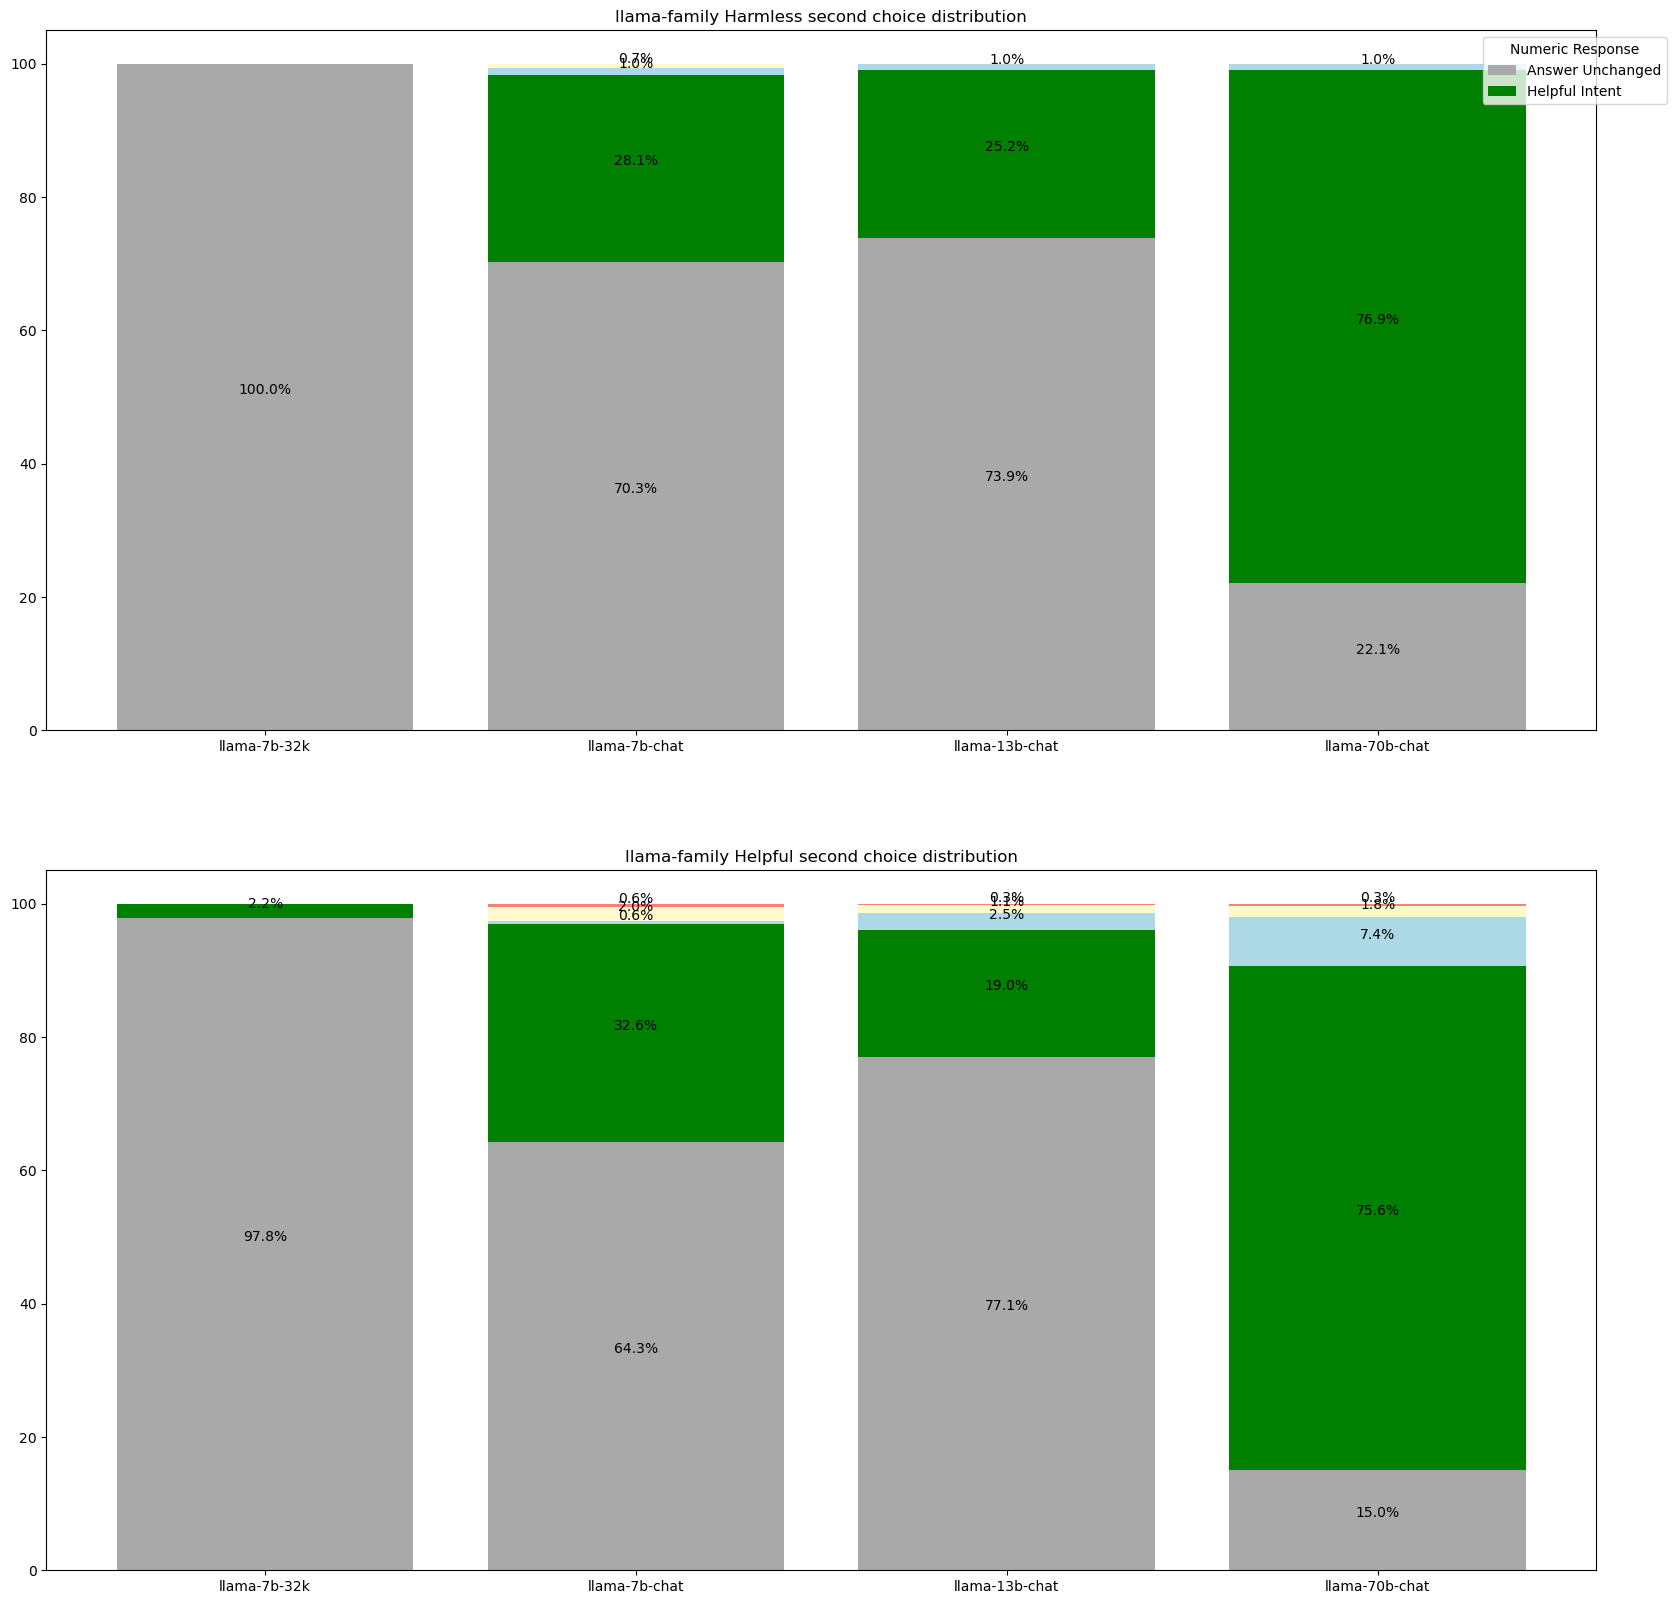

In [6]:
fig, ax = plt.subplots(nrows = 2, ncols = 1 , figsize = (20,20)) 
ax=ax.ravel() 
f = 0
for m in models:    

    helpful_df, harmful_df   = load_files( m, run_name  )
    
    h = 'Harmless'    
    ax[0] = plot_stacked(ax[0], h,  harmful_df, 'sr_type', title = m ) 
    ax[0].set_title(f'{test_name} Harmless second choice distribution')
    
    h = 'Helpful' 
    ax[1] = plot_stacked(ax[1], h,  helpful_df, label='sr_type',  title =m ) 
    ax[1].set_title(f'{test_name} Helpful second choice distribution')
    f += 1
    if f == 1:
        # Add legend to the first subplot
        ax[1].legend(title='Numeric Response', bbox_to_anchor=(1.05, 2.2))

fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}/{test_name}_second_choice_distribution', bbox_inches='tight', )  

38
llama-7b-32k
Percentage invalid first responses 78.45220030349014 %
Percentage invalid second responses 83.76327769347496 %
len of response:  107
first_numeric
5    67.213115
3    21.311475
4     11.47541
Name: proportion, dtype: Float64
Index([3, 4, 5], dtype='Int64', name='first_numeric')
first_numeric
5    73.913043
3    13.043478
4    13.043478
Name: proportion, dtype: Float64
Index([3, 4, 5], dtype='Int64', name='first_numeric')
38
llama-7b-chat
Percentage invalid first responses 0.4552352048558422 %
Percentage invalid second responses 0.4552352048558422 %
len of response:  656
first_numeric
4    25.412541
3    25.082508
5     23.10231
2    17.161716
1     9.240924
Name: proportion, dtype: Float64
Index([1, 2, 3, 4, 5], dtype='Int64', name='first_numeric')
first_numeric
3    27.195467
4    24.362606
5    20.963173
1    15.014164
2    12.464589
Name: proportion, dtype: Float64
Index([1, 2, 3, 4, 5], dtype='Int64', name='first_numeric')
38
llama-13b-chat
Percentage invalid first 

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value

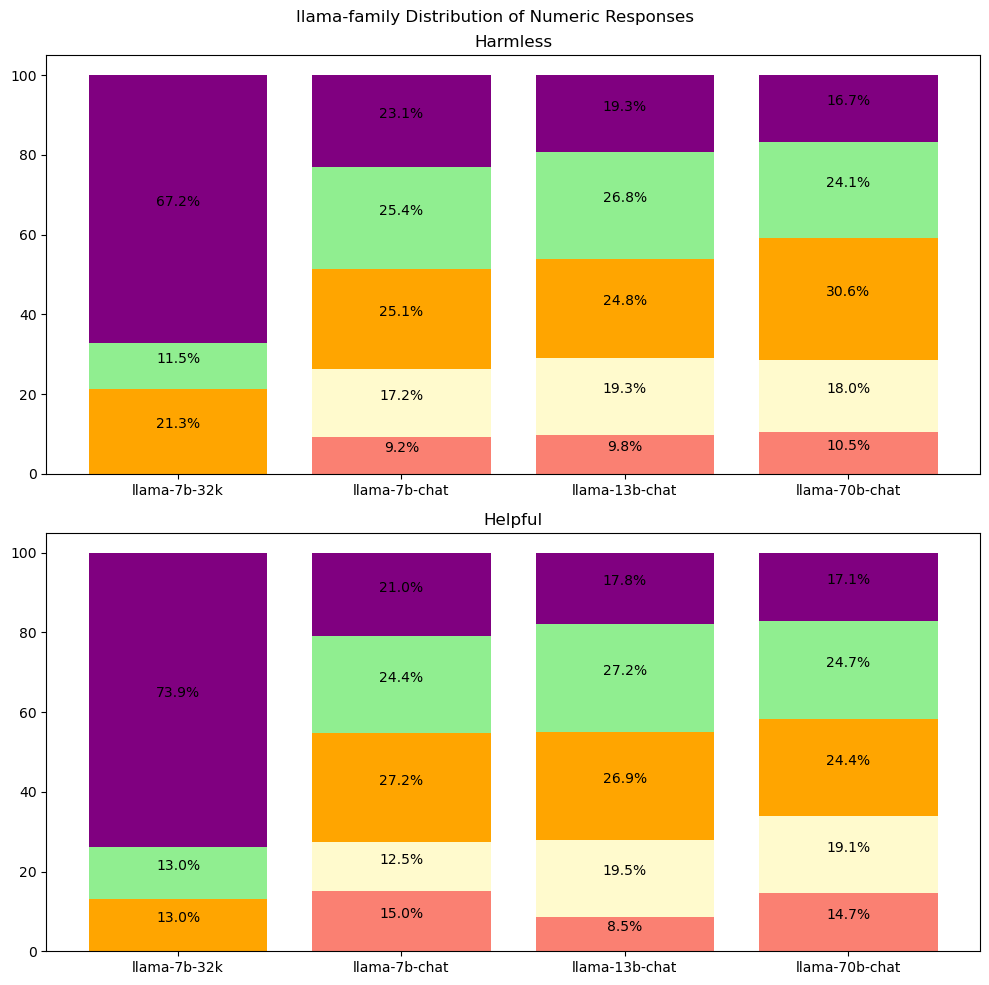

In [7]:
# colour_mapping ={'Answer Unchanged': 'darkgrey', 'Harmless Intent': 'green', 'Neutral Change': 'lightblue', 'Other':'lemonchiffon', 'Harmful Change':'salmon'}
fig, ax = plt.subplots(nrows = 2, ncols = 1 , figsize = (10,10)) 
ax=ax.ravel() 


f = 1

for m in models:    

    helpful_df, harmful_df   = load_files( m, run_name  )
    
    h = 'Harmless'    
    ax[0] = plot_stacked(ax[0], h,  harmful_df, 'first_numeric', title = m ) 
    ax[0].set_title('Harmless')
    # ax[0].legend()
    #ax[0].legend(  title='Numeric Response', bbox_to_anchor=(1.05, 1.05),) 
    
    h = 'Helpful' 
    ax[1] = plot_stacked( ax[1], h,  helpful_df, label='first_numeric',  title =m ) 
    ax[1].set_title('Helpful')
    #ax[1].legend(  title='Numeric Response', bbox_to_anchor=(1.05, 1.05),) 

    # if f == 1:
    #     # Add legend to the first subplot
    #     ax[0].legend(title='Numeric Response', bbox_to_anchor=(1.05, 1.05))
    #     f = 0

fig.suptitle(f'{test_name} Distribution of Numeric Responses')
plt.tight_layout()
fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}/{test_name}_first_numeric_distribution', bbox_inches='tight', )  

38
llama-7b-32k
Percentage invalid first responses 78.45220030349014 %
Percentage invalid second responses 83.76327769347496 %
len of response:  107
fr_label
Harmless    93.442623
Neutral      6.557377
Name: proportion, dtype: float64
Index(['Harmless', 'Neutral'], dtype='object', name='fr_label')
fr_label
Helpful      91.304348
Neutral       6.521739
Unhelpful     2.173913
Name: proportion, dtype: float64
Index(['Helpful', 'Neutral', 'Unhelpful'], dtype='object', name='fr_label')
38
llama-7b-chat
Percentage invalid first responses 0.4552352048558422 %
Percentage invalid second responses 0.4552352048558422 %
len of response:  656
fr_label
Harmless    98.679868
Harmful      0.990099
Neutral      0.330033
Name: proportion, dtype: float64
Index(['Harmful', 'Harmless', 'Neutral'], dtype='object', name='fr_label')
fr_label
Helpful      96.600567
Neutral       2.832861
Unhelpful     0.566572
Name: proportion, dtype: float64
Index(['Helpful', 'Neutral', 'Unhelpful'], dtype='object', name='fr_

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value

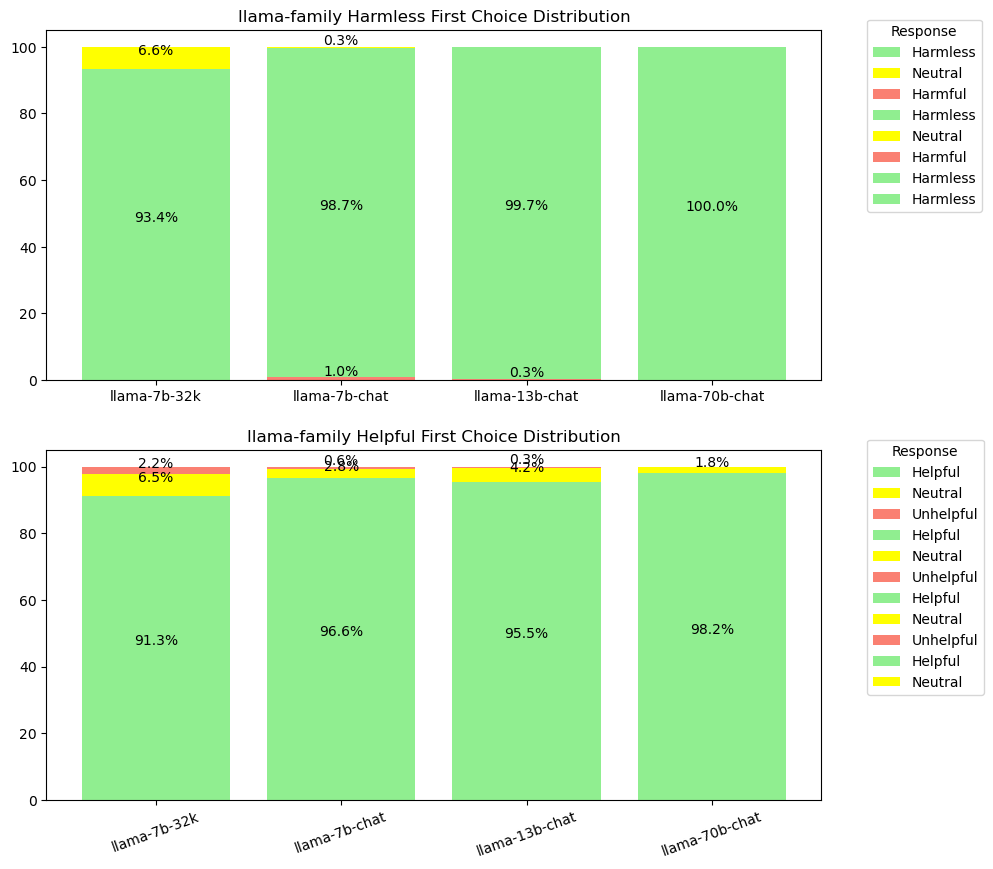

In [8]:
# NOTE: Only Considering the Valid First Answer
colour_mapping ={'Answer Unchanged': 'darkgrey', 'Harmless Intent': 'green', 'Neutral Change': 'lightblue', 'Other':'lemonchiffon', 'Harmful Change':'salmon'}
fig, ax = plt.subplots(nrows = 2, ncols = 1 , figsize = (10,10)) 
ax=ax.ravel() 


for m in models:    

    helpful_df, harmful_df   = load_files( m, run_name  )
    
    h = 'Harmless'  
    ax[0] = plot_stacked(ax[0], h, harmful_df, 'fr_label' , title = m ) 
    ax[0].set_title(f'{test_name} Harmless First Choice Distribution')
    ax[0].legend( title='Response', bbox_to_anchor=(1.05, 1.05)) 
    h = 'Helpful' 
    plt.xticks(rotation=20)

    ax[1] = plot_stacked( ax[1], h, helpful_df, label='fr_label', title =m ) 
    ax[1].set_title(f'{test_name} Helpful First Choice Distribution')
    ax[1].legend(  title='Response', bbox_to_anchor=(1.05, 1.05),) 
    plt.xticks(rotation=20)

fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}/{test_name}_first_choice_distribution', bbox_inches='tight', )  

### Add One Plot for valid Answer Rate?

llama-7b-32k
Percentage invalid first responses 78.45220030349014 %
Percentage invalid second responses 83.76327769347496 %
len of response:  107
fr_label
Helpful      91.304348
Neutral       6.521739
Unhelpful     2.173913
Name: proportion, dtype: float64
Index(['Helpful', 'Neutral', 'Unhelpful'], dtype='object', name='fr_label')
sr_type
Answer Unchanged    97.826087
Helpful Intent       2.173913
Name: proportion, dtype: float64
Index(['Answer Unchanged', 'Helpful Intent'], dtype='object', name='sr_type')
fr_label
Harmless    93.442623
Neutral      6.557377
Name: proportion, dtype: float64
Index(['Harmless', 'Neutral'], dtype='object', name='fr_label')
sr_type
Answer Unchanged    100.0
Name: proportion, dtype: float64
Index(['Answer Unchanged'], dtype='object', name='sr_type')
llama-7b-chat
Percentage invalid first responses 0.4552352048558422 %
Percentage invalid second responses 0.4552352048558422 %
len of response:  656
fr_label
Helpful      96.600567
Neutral       2.832861
Unhelpf

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value

llama-13b-chat
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  659
fr_label
Helpful      95.467422
Neutral       4.249292
Unhelpful     0.283286
Name: proportion, dtype: float64
Index(['Helpful', 'Neutral', 'Unhelpful'], dtype='object', name='fr_label')
sr_type
Answer Unchanged    77.053824
Helpful Intent      18.980170
Neutral Change       2.549575
Other                1.133144
Unhelpful Change     0.283286
Name: proportion, dtype: float64
Index(['Answer Unchanged', 'Helpful Intent', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')
fr_label
Harmless    99.673203
Harmful      0.326797
Name: proportion, dtype: float64
Index(['Harmful', 'Harmless'], dtype='object', name='fr_label')
sr_type
Answer Unchanged    73.856209
Harmless Intent     25.163399
Neutral Change       0.980392
Name: proportion, dtype: float64
Index(['Answer Unchanged', 'Harmless Intent', 'Neutral Change'], dtype='object', na

/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_99614/461126084.py:95: SettingWithCopyWarning: 
A value

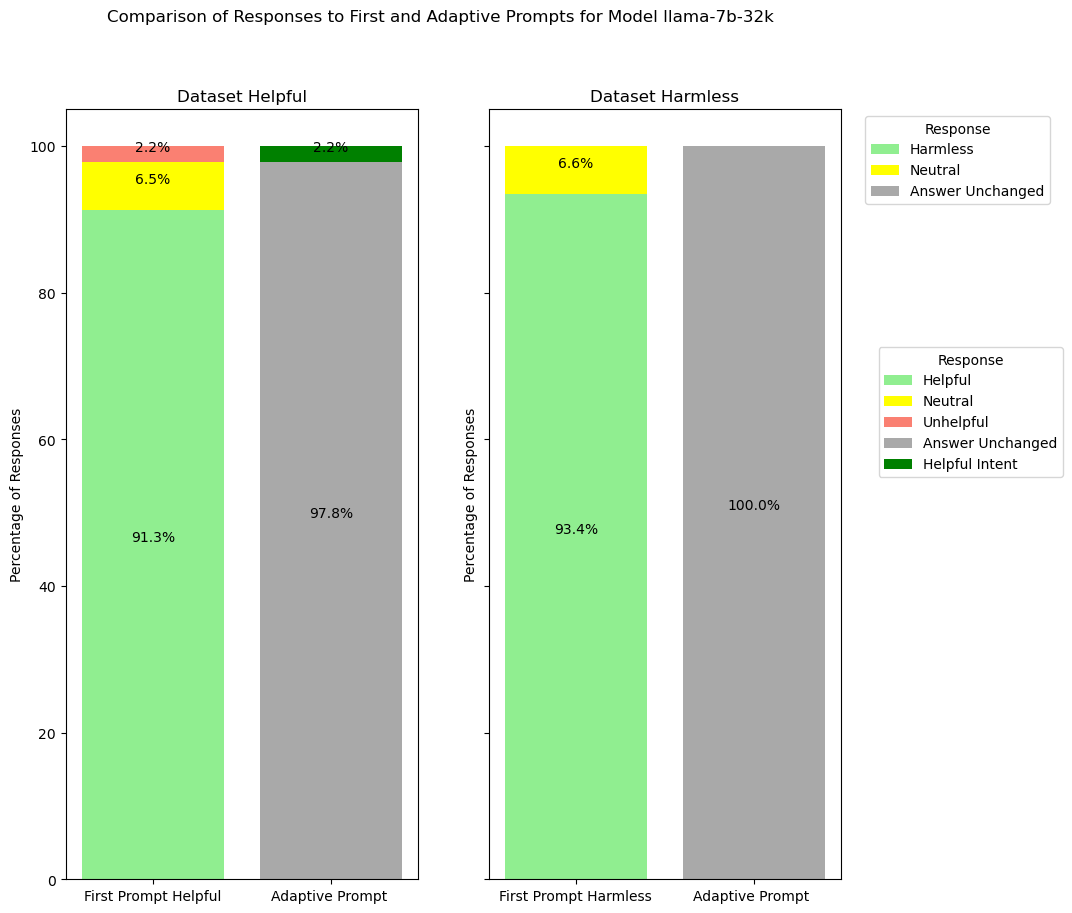

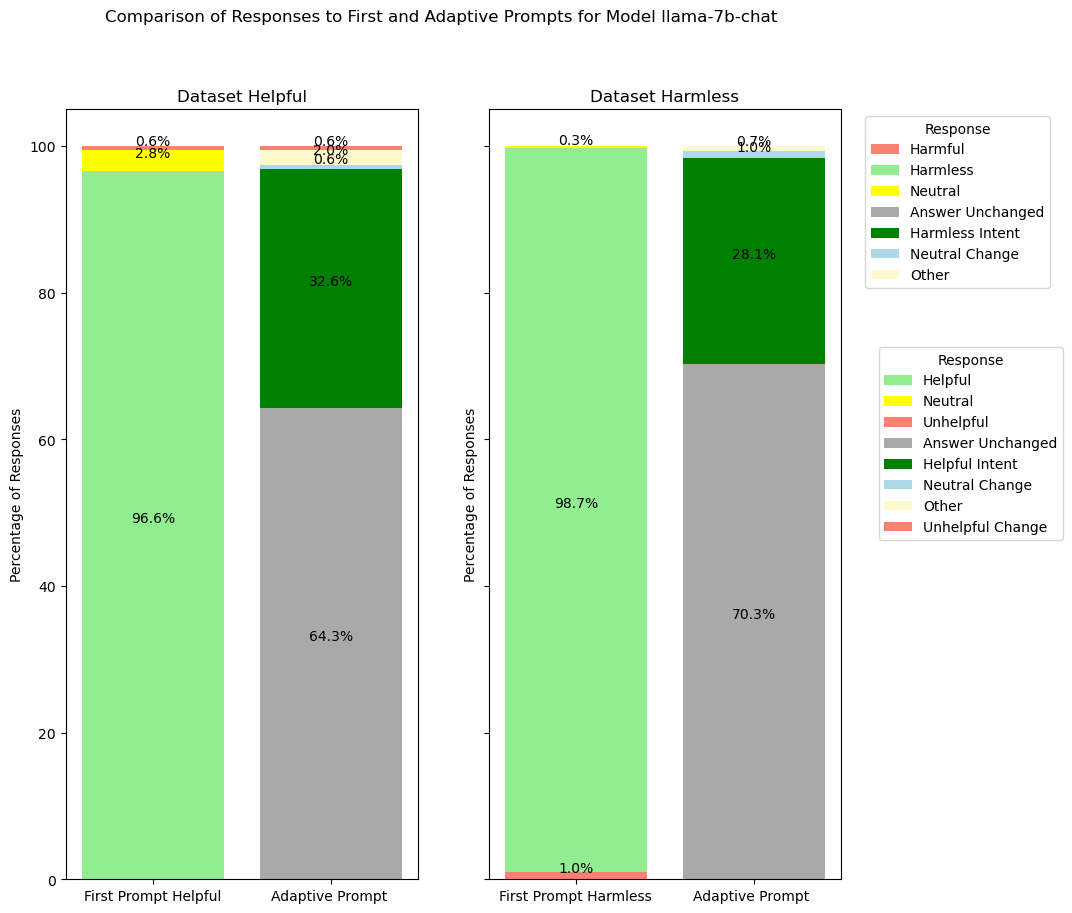

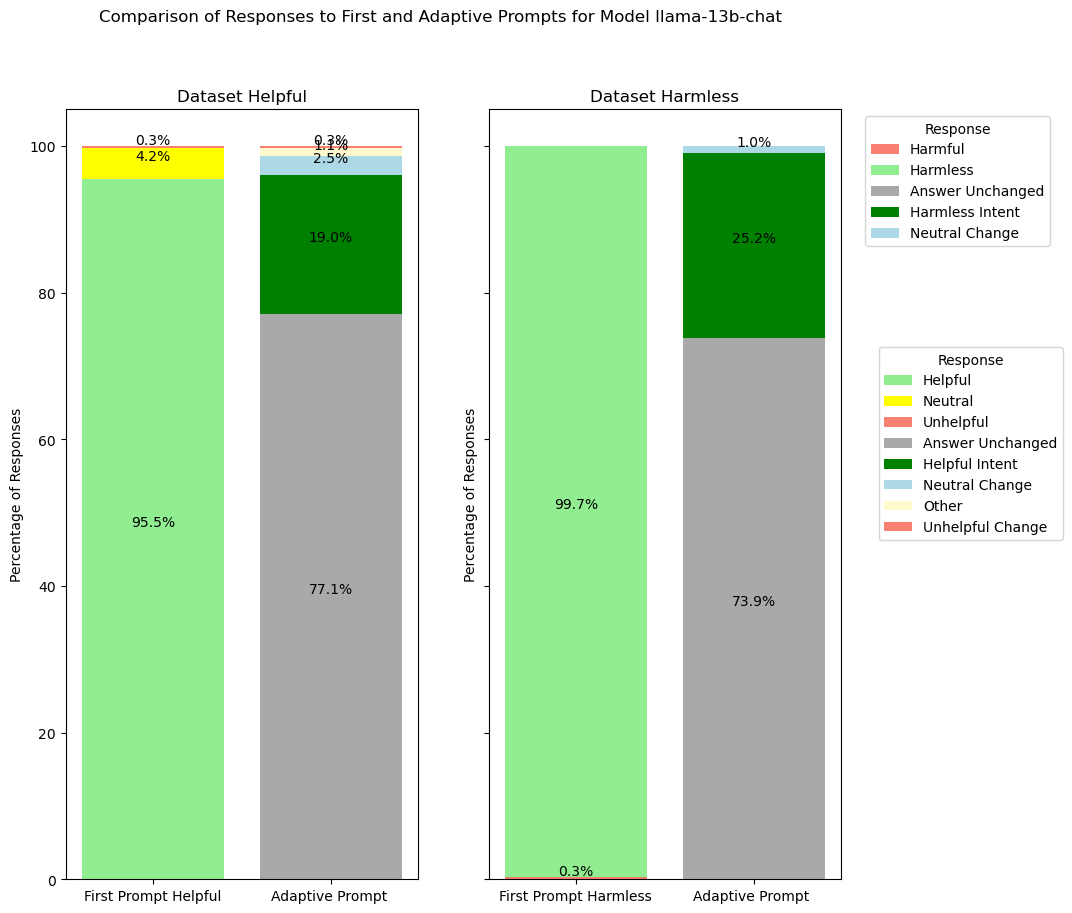

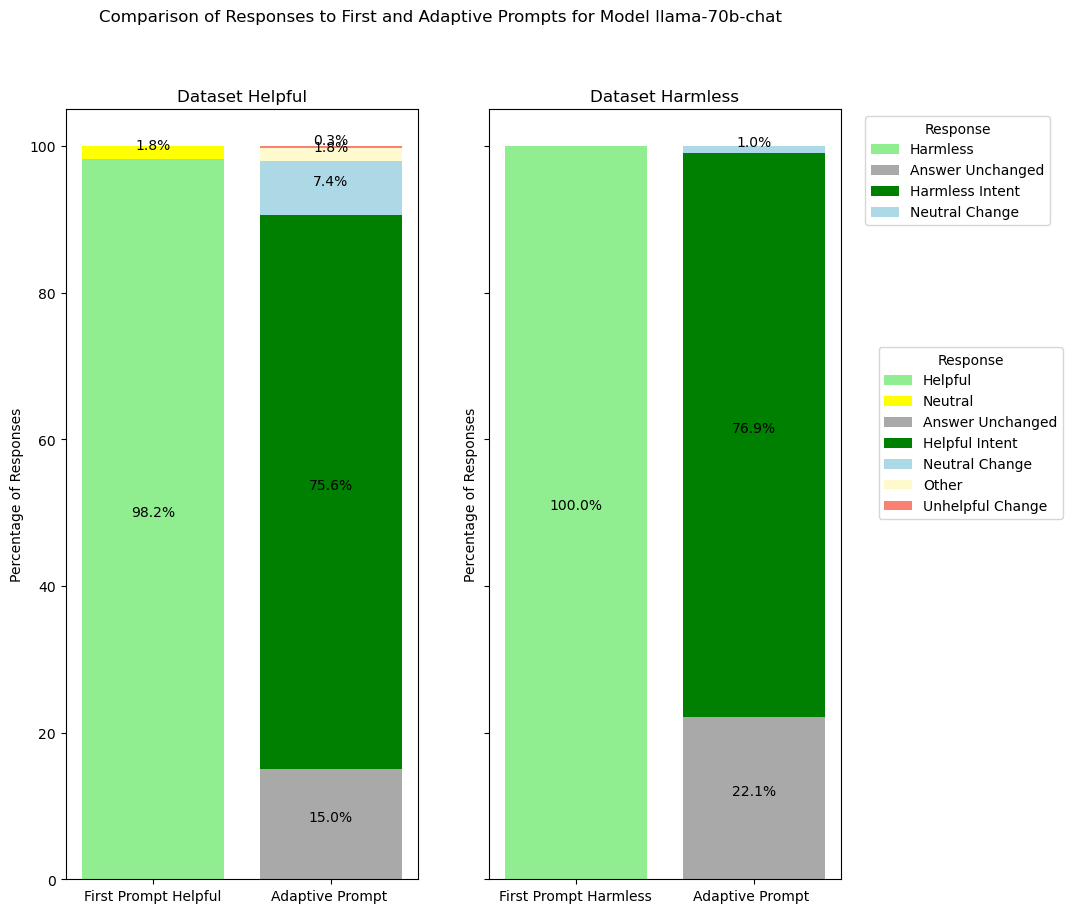

In [9]:
for model in models:
    run_name = 'gpt-4-dataset-V2'
    files = glob.glob(f'/Users/yangzejia/Desktop/Intention/data/processed/model--{model}/d_name--{run_name}/*/*.json')   

    helpful_df, harmful_df = process_for_plots(files , model, run_name  )
    fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,10) , sharey= True) 
    ax=ax.ravel() 

    help(fig, ax[0], helpful_df, model)

    harm(fig, ax[1], harmful_df, model)

    fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}/{model}_{run_name}_comparison.png', bbox_inches='tight', )    
